# B. State purification with qubit-mediated measurement

In [1]:
# ruff: noqa
import os

os.sys.path.append("..")
from feedback_grape.fgrape import optimize_pulse_with_feedback
import jax.numpy as jnp

## The cavity is initially in a  mixed state --> Goal is to purify the state

We are trying to maximize the property determined by $tr (\rho_{\text{cav}}^2)$ which is the purity

In the following, we consider an adaptive measurement
scheme, demonstrated in a series of experiments on Rydberg atoms interacting
with microwave cavities. In this scheme, the
cavity is coupled to an ancilla qubit, which can then be
read out to update our knowledge of the quantum state of
the cavity.

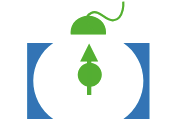

In [2]:
# initial state is a thermal state
n_average = 2
N_cavity = 30
# natural logarithm
beta = jnp.log((1 / n_average) + 1)
diags = jnp.exp(-beta * jnp.arange(N_cavity))
normalized_diags = diags / jnp.sum(diags, axis=0)
rho_cav = jnp.diag(normalized_diags)

### Now the thing is here, we don't need a rho_final because the purity or the reward that we want to maximize is $tr (\rho_{\text{cav}}^2)$.
Unlike fidelity expressions which wants to find how close to states are

## Next Step is to construct our POVM

In [3]:
from feedback_grape.utils.operators import cosm, sinm

In [4]:
from feedback_grape.utils.operators import create, destroy
import jax


def povm_measure_operator(measurement_outcome, gamma, delta):
    """
    POVM for the measurement of the cavity state.
    returns Mm ( NOT the POVM element Em = Mm_dag @ Mm ), given measurement_outcome m, gamma and delta
    """
    number_operator = create(N_cavity) @ destroy(N_cavity)
    angle = (gamma * number_operator) + delta / 2
    return jnp.where(
        measurement_outcome == 1,
        cosm(angle),
        sinm(angle),
    )

In [5]:
# Answer: why does RNN outputs two the same, then two the same, then two the same and so on? -> calculate during forward proagation then again during back_propagation

measure = {
    "gate": povm_measure_operator,
    "initial_params": jax.random.uniform(key=jax.random.PRNGKey(42), shape=(1,2), minval=0.0, maxval=jnp.pi)[0].tolist(),
    "measurement_flag": True,
    "param_constraints": [[0, jnp.pi], [-2*jnp.pi, 2*jnp.pi]], # if this is commented and no bouds the avg purity would be 0.91 and highest purity of a measurement sequence is 0.997
}

system_params = [measure]

result = optimize_pulse_with_feedback(
    U_0=rho_cav,
    C_target=None,
    system_params=system_params,
    num_time_steps=5,
    mode="lookup",
    goal="purity",
    max_iter=1000,
    convergence_threshold=1e-20,
    learning_rate=0.01,
    type="density",
    batch_size=10,
)

Iteration 0, Loss: 0.862880
Iteration 10, Loss: 1.135510
Iteration 20, Loss: 1.077715
Iteration 30, Loss: 1.357428
Iteration 40, Loss: 1.313053
Iteration 50, Loss: 1.348599
Iteration 60, Loss: 1.362321
Iteration 70, Loss: 1.239793
Iteration 80, Loss: 1.479631
Iteration 90, Loss: 1.400766
Iteration 100, Loss: 1.613997
Iteration 110, Loss: 1.450858
Iteration 120, Loss: 1.424572
Iteration 130, Loss: 1.306259
Iteration 140, Loss: 1.362376
Iteration 150, Loss: 1.439801
Iteration 160, Loss: 1.367622
Iteration 170, Loss: 1.376426
Iteration 180, Loss: 1.532456
Iteration 190, Loss: 1.310603
Iteration 200, Loss: 1.261063
Iteration 210, Loss: 1.449026
Iteration 220, Loss: 1.193133
Iteration 230, Loss: 1.339425
Iteration 240, Loss: 1.476859
Iteration 250, Loss: 1.135262
Iteration 260, Loss: 1.647552
Iteration 270, Loss: 1.403686
Iteration 280, Loss: 1.551668
Iteration 290, Loss: 1.290121
Iteration 300, Loss: 1.483744
Iteration 310, Loss: 1.249323
Iteration 320, Loss: 1.356683
Iteration 330, Loss: 

In [6]:
result

FgResult(optimized_trainable_parameters={'initial_params': [Array([1.49980567, 1.15099061], dtype=float64)], 'lookup_table': [[Array([0.3787563 , 1.56613345], dtype=float64), Array([0.39831432, 2.34496725], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0., 0.], dtype=float64), Array([0.

In [7]:
print(result.final_fidelity)

None


In [8]:
print(result.final_state)

[[[ 2.49491816e-03+0.j  4.72210936e-03+0.j  1.31865337e-02+0.j ...
   -1.94987588e-03+0.j -1.35412468e-03+0.j -1.18280014e-03+0.j]
  [ 4.72210936e-03+0.j  1.02993995e-02+0.j  2.83305239e-02+0.j ...
   -4.53531729e-03+0.j -2.75949690e-03+0.j -2.42964775e-03+0.j]
  [ 1.31865337e-02+0.j  2.83305239e-02+0.j  7.89692729e-02+0.j ...
   -1.19873945e-02+0.j -7.69899580e-03+0.j -6.74503088e-03+0.j]
  ...
  [-1.94987588e-03+0.j -4.53531729e-03+0.j -1.19873945e-02+0.j ...
    3.10498310e-03+0.j  1.17132627e-03+0.j  1.09904484e-03+0.j]
  [-1.35412468e-03+0.j -2.75949690e-03+0.j -7.69899580e-03+0.j ...
    1.17132627e-03+0.j  7.81234287e-04+0.j  6.81257905e-04+0.j]
  [-1.18280014e-03+0.j -2.42964775e-03+0.j -6.74503088e-03+0.j ...
    1.09904484e-03+0.j  6.81257905e-04+0.j  6.06187705e-04+0.j]]

 [[ 8.75565118e-01+0.j -2.50800708e-01+0.j -1.33087401e-01+0.j ...
   -7.26658876e-03+0.j -4.42815100e-03+0.j -4.92961383e-03+0.j]
  [-2.50800708e-01+0.j  7.38024805e-02+0.j  3.69670746e-02+0.j ...
    2.03

In [9]:
result.optimized_trainable_parameters['lookup_table']

[[Array([0.3787563 , 1.56613345], dtype=float64),
  Array([0.39831432, 2.34496725], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.], dtype=float64),
  Array([0., 0.]

In [10]:
# 0.9163363647226792
print(result.final_purity)

0.9514429343491289


In [11]:
from feedback_grape.utils.purity import purity

# the highest purity can be 0.995 if the initial params that initializes the lookup table
# are between 0 and pi rather than -pi and pi
print("initial purity:", purity(rho=rho_cav))
for i, state in enumerate(result.final_state):
    print(f"Purity of state {i}:", purity(rho=state))

initial purity: 0.20000208604889932
Purity of state 0: 0.9650149581593409
Purity of state 1: 0.9803794445339018
Purity of state 2: 0.9345726357655965
Purity of state 3: 0.9803794445339018
Purity of state 4: 0.9317347817010945
Purity of state 5: 0.9357636290963711
Purity of state 6: 0.9358161847007916
Purity of state 7: 0.9345726357655965
Purity of state 8: 0.9803794445339018
Purity of state 9: 0.9358161847007916


In [12]:
result.returned_params

[[Array([[1.49980567, 1.15099061],
         [1.49980567, 1.15099061],
         [1.49980567, 1.15099061],
         [1.49980567, 1.15099061],
         [1.49980567, 1.15099061],
         [1.49980567, 1.15099061],
         [1.49980567, 1.15099061],
         [1.49980567, 1.15099061],
         [1.49980567, 1.15099061],
         [1.49980567, 1.15099061]], dtype=float64)],
 [Array([[0.39831432, 2.34496725],
         [0.3787563 , 1.56613345],
         [0.39831432, 2.34496725],
         [0.3787563 , 1.56613345],
         [0.3787563 , 1.56613345],
         [0.3787563 , 1.56613345],
         [0.3787563 , 1.56613345],
         [0.39831432, 2.34496725],
         [0.3787563 , 1.56613345],
         [0.3787563 , 1.56613345]], dtype=float64)],
 [Array([[ 0.50649578, -5.40024928],
         [ 1.98313625, -5.43392844],
         [ 0.27258586, -2.96780576],
         [ 1.98313625, -5.43392844],
         [ 2.16457024, -6.28640135],
         [ 1.98313625, -5.43392844],
         [ 2.16457024, -6.28640135],
     

In [13]:
print(jax.random.PRNGKey(9))
time_step_keys = jax.random.split(jax.random.PRNGKey(9), 5)
print(time_step_keys)
for key in time_step_keys:
    print(jax.random.uniform(key))

[0 9]
[[2822284597 2722679661]
 [ 143080583 4281670255]
 [2676565412 4109519897]
 [1877436067 1979300842]
 [3339921199 4267639851]]
0.16232149317805766
0.07829857808883056
0.8422083576204116
0.23698051656885277
0.33005660981143814


In [72]:
from feedback_grape.fgrape import povm
import random

time_steps = 5

rho = rho_cav
print("initial purity:", purity(rho=rho))
param_constraints = measure['param_constraints']


rand_num = random.randint(1, 50)

time_step_keys = jax.random.split(jax.random.PRNGKey(rand_num), time_steps)
for i in range(time_steps):
    params = result.returned_params[i][0]
    print(f"params for time step {i}:", params[0])
    rho, _, _ = povm(rho, povm_measure_operator, params[0], gate_param_constraints=param_constraints, rng_key=time_step_keys[i])
    print(f"purity of rho after time step {i}", purity(rho=rho))
final_rho_cav = rho

initial purity: 0.20000208604889932
params for time step 0: [1.49980567 1.15099061]
purity of rho after time step 0 0.3618141464488159
params for time step 1: [0.39831432 2.34496725]
purity of rho after time step 1 0.5917530390777338
params for time step 2: [ 0.50649578 -5.40024928]
purity of rho after time step 2 0.8039452723030401
params for time step 3: [ 2.31973233 -6.15600858]
purity of rho after time step 3 0.827497582138122
params for time step 4: [0.95106811 3.39476339]
purity of rho after time step 4 0.8964216231488015


In [73]:
from feedback_grape.utils.povm import (
    _probability_of_a_measurement_outcome_given_a_certain_state,
)

variables = jnp.array([0.1, -3 * jnp.pi / 2])
# variables_2 = {
#     "gamma": 0.1,
#     "delta": -3 * jnp.pi / 2,
# }
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, -1, povm_measure_operator, variables
    )
)
print(
    _probability_of_a_measurement_outcome_given_a_certain_state(
        rho_cav, 1, povm_measure_operator, variables
    )
)

0.0973540364721641
0.9026459635278362


### Check stash for replacement of dict implementation

In [74]:
print("Final state after application of amplitudes:", final_rho_cav)

Final state after application of amplitudes: [[ 8.41586537e-01+0.j -2.71913636e-01+0.j -6.99011671e-02+0.j
  -3.58449746e-02+0.j -3.68103836e-02+0.j -3.63089525e-02+0.j
  -3.19491724e-02+0.j -2.79879798e-02+0.j -1.65726349e-02+0.j
  -9.48998595e-03+0.j -1.99451592e-02+0.j -1.56390201e-02+0.j
  -1.74570808e-02+0.j  1.06994309e-03+0.j -2.13433724e-02+0.j
  -9.68467273e-03+0.j -9.88171227e-03+0.j -1.86801364e-02+0.j
  -7.52143808e-03+0.j -7.76205959e-03+0.j -6.19297397e-03+0.j
  -3.47482277e-03+0.j -3.78749852e-03+0.j -5.19910288e-03+0.j
  -5.67938538e-03+0.j -3.35457769e-03+0.j -1.33859869e-02+0.j
  -4.79304022e-03+0.j -5.02453127e-03+0.j -4.52590958e-03+0.j]
 [-2.71913636e-01+0.j  9.14056143e-02+0.j  2.17064721e-02+0.j
   1.22902125e-02+0.j  1.24806429e-02+0.j  1.27681729e-02+0.j
   1.27282092e-02+0.j  7.23681371e-03+0.j  5.18652319e-03+0.j
   3.10007160e-03+0.j  6.45779544e-03+0.j  4.88714480e-03+0.j
   5.48995639e-03+0.j -7.86845515e-05+0.j  6.79173802e-03+0.j
   3.24717150e-03+0.j  3

In [75]:
print("Final state from solver:", result.final_state)

Final state from solver: [[[ 2.49491816e-03+0.j  4.72210936e-03+0.j  1.31865337e-02+0.j ...
   -1.94987588e-03+0.j -1.35412468e-03+0.j -1.18280014e-03+0.j]
  [ 4.72210936e-03+0.j  1.02993995e-02+0.j  2.83305239e-02+0.j ...
   -4.53531729e-03+0.j -2.75949690e-03+0.j -2.42964775e-03+0.j]
  [ 1.31865337e-02+0.j  2.83305239e-02+0.j  7.89692729e-02+0.j ...
   -1.19873945e-02+0.j -7.69899580e-03+0.j -6.74503088e-03+0.j]
  ...
  [-1.94987588e-03+0.j -4.53531729e-03+0.j -1.19873945e-02+0.j ...
    3.10498310e-03+0.j  1.17132627e-03+0.j  1.09904484e-03+0.j]
  [-1.35412468e-03+0.j -2.75949690e-03+0.j -7.69899580e-03+0.j ...
    1.17132627e-03+0.j  7.81234287e-04+0.j  6.81257905e-04+0.j]
  [-1.18280014e-03+0.j -2.42964775e-03+0.j -6.74503088e-03+0.j ...
    1.09904484e-03+0.j  6.81257905e-04+0.j  6.06187705e-04+0.j]]

 [[ 8.75565118e-01+0.j -2.50800708e-01+0.j -1.33087401e-01+0.j ...
   -7.26658876e-03+0.j -4.42815100e-03+0.j -4.92961383e-03+0.j]
  [-2.50800708e-01+0.j  7.38024805e-02+0.j  3.6967

In [76]:
# # Define initial state (a thermal state for example)
# import os

# os.sys.path.append("..")
# from feedback_grape.fgrape import optimize_pulse_with_feedback
# from feedback_grape.utils.operators import create, destroy, cosm, sinm
# import jax.numpy as jnp

# n_average = 2
# N_cavity = 30
# beta = jnp.log((1 / n_average) + 1)
# diags = jnp.exp(-beta * jnp.arange(N_cavity))
# normalized_diags = diags / jnp.sum(diags, axis=0)
# rho_cav = jnp.diag(normalized_diags)


# def povm_measure_operator(measurement_outcome, gamma, delta):
#     """
#     POVM for the measurement of the cavity state.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return jnp.where(
#         measurement_outcome == 1,
#         cosm(angle),
#         sinm(angle),
#     )


# def unitary_gate(gamma, delta):
#     """
#     Example unitary gate operation.
#     """
#     number_operator = create(N_cavity) @ destroy(N_cavity)
#     angle = (gamma * number_operator) + delta / 2
#     return cosm(angle)


# # Initial parameters for both gates NOTE those are really important
# initial_params = {
#     "POVM": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
#     "U_qc": {
#         "gamma": jnp.pi / 2,
#         "delta": jnp.pi / 2,
#     },
# }

# # Run the optimization
# result = optimize_pulse_with_feedback(
#     U_0=rho_cav,
#     C_target=None,
#     parameterized_gates=[povm_measure_operator, unitary_gate],
#     measurement_indices=[0],  # Only the first gate is a measurement
#     initial_params=initial_params,
#     num_time_steps=5,
#     mode="nn",
#     goal="purity",
#     optimizer="adam",
#     max_iter=1000,
#     convergence_threshold=1e-6,
#     learning_rate=0.1,
#     type="density",
# )

# print(f"Final purity: {result.final_purity}")

In [77]:
import jax.numpy as jnp
import jax

initial_params = {
    "POVM": [0.1, 0.2],
    "test": [0.3, 0.4],
    "test2": 0.5,
    "test3": [0.1],
}


# refer to the old ways in older commits to keep the order while using nested dicts - does not use tree utils though
def flatten_dict(d):
    res = []
    shapes = []
    for value in d.values():
        flat_params = jax.tree_util.tree_leaves(value)
        res.append(flat_params)
        shapes.append(len(flat_params))
    return res, shapes


flat_params, shapes = flatten_dict(initial_params)
print(flat_params)
print(shapes)

[[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]
[2, 2, 1, 1]


In [78]:
print("restored_params", flat_params)

restored_params [[0.1, 0.2], [0.3, 0.4], [0.5], [0.1]]


In [79]:
jnp.array([0.1, 0.2, 0.2])

Array([0.1, 0.2, 0.2], dtype=float64)

In [80]:
batch_size = 2

In [81]:
rho_final_batched = jnp.repeat(jnp.expand_dims(rho_cav, 0), batch_size, axis=0)

In [82]:
rho_final_batched.shape

(2, 30, 30)

In [83]:
parent_key = jax.random.PRNGKey(0)
print(parent_key.shape)
rng_keys = jax.random.split(parent_key)

(2,)


In [84]:
rng_keys[0].shape

(2,)

In [85]:
print(jnp.array([1, 3]) * -jnp.array([2, 2]))

[-2 -6]


In [86]:
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)


In [87]:
initial_params = {
    "qubit_unitary": [0.1, 0.1],
    "qubit_cavity_unitary": [0.2, 0.2],
}
param_constraints = [[[0, 0.5], [0.5, 1.0]], [[1.0, 1.5], [1.5, 2.0]]]



In [88]:
def construct_ragged_row(num_of_rows, num_of_columns, param_constraints, rng_key):
    res = []
    for i in range(num_of_rows):
        row = []
        for j in range(num_of_columns):
            rng_key, subkey = jax.random.split(rng_key)
            val = jax.random.uniform(
                subkey,
                shape=(),
                minval=param_constraints[j][0],
                maxval=param_constraints[j][1],
            )
            row.append(val)
        res.append(jnp.array(row))
    return res

In [89]:
h_initial_state = None
rnn_model = None
# step 1: initialize the parameters
num_of_columns = 4
num_of_sub_lists = 1 * 5
F = []
param_constraints_reshaped = jnp.array(param_constraints).reshape(-1, 2)
# construct ragged lookup table
row_key = jax.random.PRNGKey(0)
for i in range(1, num_of_sub_lists + 1):
    row_key, _ = jax.random.split(row_key)
    F.append(
        construct_ragged_row(
            num_of_rows=2**i,
            num_of_columns=num_of_columns,
            param_constraints=param_constraints_reshaped,
            rng_key=row_key,
        )
    )
# step 2: pad the arrays to have the same number of rows
min_num_of_rows = 2 ** len(F)
for i in range(len(F)):
    if len(F[i]) < min_num_of_rows:
        zeros_arrays = [
            jnp.zeros((num_of_columns,), dtype=jnp.float64)
            for _ in range(min_num_of_rows - len(F[i]))
        ]
        F[i] = F[i] + zeros_arrays

F

[[Array([0.33559649, 0.67583317, 1.07987065, 1.98053433], dtype=float64),
  Array([0.11240873, 0.64456978, 1.07282654, 1.92680755], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0., 0., 0., 0.], dtype=float64),
  Array([0.,

In [90]:
def construct_ragged_row(num_of_rows, num_of_columns, param_constraints, rng_key):
    res = []
    for i in range(num_of_rows):
        print(param_constraints[0][0])
        flattened = jax.random.uniform(
            rng_key,
            shape=(num_of_columns,),
            minval=param_constraints[i][0],
            maxval=param_constraints[i][1],
            dtype=jnp.float64,
        )
        res.append(flattened)
    return res


In [91]:
param_constraints =  [[0, 0.5]],
